In [157]:
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import netCDF4
from meteostat import Stations
import os

nearest_station = []
df_final = pd.DataFrame()
    
for file in os.listdir( 'P:\\Trees'):
    filename = os.fsdecode(file)
    if filename.startswith('rainfall_hadukgrid_uk_60km_ann_'):

        path = f'P:\\Trees\\{filename}'
        nc = netCDF4.Dataset(path)

        # nc.variables.keys()

        #=======================
        # Extract relevant attributes from nc file

        rainfall_data = nc.variables['rainfall'][:]
        rainfall_data = rainfall_data.data.flatten()
        latitude_data = nc.variables['latitude'][:]
        latitude_data = latitude_data.filled(np.nan).flatten()
        longitude_data = nc.variables['longitude'][:]
        longitude_data = longitude_data.filled(np.nan).flatten()

        #========================
        # Convert time to human readable timestamp
        time = nc.variables['time']
        time_data = nc.variables['time'][:]
        base_time = time.units.split('since')[-1].strip()
        base_time = datetime.strptime(base_time, '%Y-%m-%d %H:%M:%S')
        date = base_time + timedelta(hours=float(time_data.filled(np.nan).flatten()[0]))

        #=======================
        # Enrich with nearest station data
        stations = Stations()
        stattions = stations.region('UK')

        for x, y in zip(longitude, latitude):
            station = stations.nearby(y,x)
            station = station.fetch(1)
            station = station['name'][0].split('/')[0].strip()
            
            if len(station) != 0:
                nearest_station.append(station['name'][0].split('/')[0].strip())
            else:
                nearest_station.append('Null')

        print(len(latitude_data), len(longitude_data), len(rainfall_data), len(nearest_station))


        rdict = {'latitude':latitude_data, 'longitude':longitude_data, 'rainfall':rainfall_data, 'nearest_station':nearest_station}
        df = pd.DataFrame(rdict)
        df['date'] = date

        df_final = pd.concat([df_final, df])

391 391 391 0


ValueError: All arrays must be of the same length

In [154]:
df_final

,latitude,longitude,rainfall,date
0,48.789596,-10.309652,1.000000e+20,2020-07-01
1,48.845471,-9.500016,1.000000e+20,2020-07-01
2,48.895685,-8.688010,1.000000e+20,2020-07-01
3,48.940200,-7.873882,1.000000e+20,2020-07-01
4,48.978981,-7.057882,1.000000e+20,2020-07-01
...,...,...,...,...
386,60.937895,0.030265,1.000000e+20,2023-07-01
387,60.916673,1.136076,1.000000e+20,2023-07-01
388,60.886393,2.239828,1.000000e+20,2023-07-01
389,60.847093,3.340807,1.000000e+20,2023-07-01


In [84]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as ec

#=========================
# Load Driver
driver = webdriver.Chrome()
url = 'http://www.forestdss.org.uk/geoforestdss'
driver.get(url)

#=========================
# Locate search bar and enter Grid Ref.
search_bar = driver.find_element(By.ID, 'gridref')
search_bar.clear()
search_bar.send_keys("NT090950")
go = driver.find_element(By.XPATH, "//input[@value='Go']")
go.click()

#=========================
# Download CSV from results
download = WebDriverWait(driver, 10).until(
    ec.presence_of_element_located((By.XPATH, "//a[contains(@href, 'EscModelServlet')]"))
)
download.click()


In [82]:
def generate_grid_ref(grid_squares):

    import random

    references = set()
    
    for grid_square in grid_squares:

        easting = random.randint(0,99)
        northing = random.randint(0,99)
        easting_str = f'{easting:03d}'
        northing_str = f'{northing:03d}'
        grid_ref = f"{grid_square}{easting_str}{northing_str}"

        references.add(grid_ref)

    return list(references)



In [95]:
grid_squares = ['SP', 'SO', 'SK']
generate_grid_ref(grid_squares)

['SP070030', 'SO049075', 'SK004068']

In [114]:
from openpyxl import Workbook
import pandas as pd
import csv

wb = Workbook()
ws = wb.active
with open('P:\ESC_NT090950.csv', 'r') as f:
    for row in csv.reader(f):
        ws.append(row)
wb.save('P:\ESC_NT090950_TEST.xlsx')

at = int(pd.read_excel('P:\ESC_NT090950_TEST.xlsx').iloc[9][1])
print(f'Accumulated Temperature: {at}')



Accumulated Temperature: 1096


In [3]:
def initiate_driver():

    from selenium import webdriver

    #=========================
    # Load Driver
    driver = webdriver.Chrome()
    
    return driver

def scrape_esc(driver, input_file_path, url = 'http://www.forestdss.org.uk/geoforestdss'):

    from selenium.webdriver.common.by import By
    from selenium.webdriver.common.keys import Keys
    from selenium.webdriver.support.select import Select
    
    driver.get(url)

    #=========================
    # Change drop down option to 'Download ESC Site Data'
    select = Select(driver.find_element(By.ID, 'select_tool'))
    select.select_by_visible_text('Download ESC Site Data')

    #=========================
    # Upload file template and download results
    form = driver.find_element(By.ID, 'esc-data')
    file_input = form.find_element(By.ID, 'esc-file')
    file_input.send_keys(input_file_path)
    form.submit()

    #=========================
    # Read in results
    # df = pd.read_csv('/Users/dougaltoms/Downloads/esc_data.csv')
    return #df

In [4]:
def convert_eastings_northing_to_lat_lon(df):

    import requests
    import pandas as pd
    import json

    requests.packages.urllib3.disable_warnings()

    lat = []
    lon = []

    for index, row in df.iterrows():
        easting = index
        northing = row['y']

        url = fr'https://webapps.bgs.ac.uk/data/webservices/CoordConvert_LL_BNG.cfc?method=BNGtoLatLng&easting={easting}&northing={northing}'
        r = requests.get(url, verify=False)
        j = json.loads(r.content.decode('utf-8'))

        lon.append(j['LONGITUDE'])
        lat.append(j['LATITUDE'])

    df['latitude'] = lat
    df['longitude'] = lon

    return df

In [5]:
def generate_sampling_locs(file_version):

    import random
    import pandas as pd

    df = pd.DataFrame({'x':[], 'y':[], 'species':[]})

    #========================
    # UK bbox in lat/lon then easting/northing
    bbox = ((9.184570,49.837982),(2.329102,59.489726)) 
    bbox = ((116315, 17883),(645170, 1075060))

    #========================
    # UK Native tree species to search for
    trees = ['POK' # Pedunculate Oak
    , 'ROK' # Red Oak
    , 'SOK' # Sessile Oak
    , 'SC' # Sweet Chestnut
    , 'SLI' # Small leaved Lime
    , 'CAR' # Common Alder
    , 'AH' # Ash
    , 'ASP' # Aspen
    , 'PBI' # Downy Birch
    , 'SBI' # Silver Birch
    , 'WCH' # Wild Cherry
    , 'WEM' # Wych Elm
    , 'HBM' # Hornbeam
    , 'SP' # Scotts Pine
    , 'BPO' # Black Poplar
    , 'ROW' # Rowan
    ]

    x = []
    y = []
    species = []

    #========================
    # Generate random east/north and add to DF with each tree species
    for i in range(1,7):
        easting = random.randint(bbox[0][0], bbox[1][0])
        northing = random.randint(bbox[0][1], bbox[1][1])
        for tree in trees:
            x.append(easting)
            y.append(northing)
            species.append(tree)
            # species.append(random.choice(trees))

    df['x'] = x
    df['y'] = y
    df['species'] = species

    #====================
    # Set index and save as csv
    df = df.set_index('x')
    if file_version != 1:
        path = f'/Users/dougaltoms/Downloads/esc_sample{file_version-1}.csv'
    else:
        path = f'/Users/dougaltoms/Downloads/esc_sample.csv'
        
    df.to_csv(path)

    return path

In [129]:
df

,y,at,ct,dams,md,smr,snr,elevation,species,yc,cyc,limitingfact,ecosuit,nvc1,nvc2,nvc3
x,,,,,,,,,,,,,,,,
319890.0,973179.0,1059,4,17,113,5.000000e+00,1.000000e+00,87,POK,0.0,2.0,SNR,0.03,W18,W16,W17
319890.0,973179.0,1059,4,17,113,5.000000e+00,1.000000e+00,87,ROK,1.0,3.0,SNR,0.18,W18,W16,W17
319890.0,973179.0,1059,4,17,113,5.000000e+00,1.000000e+00,87,SOK,2.0,3.0,SNR,0.29,W18,W16,W17
319890.0,973179.0,1059,4,17,113,5.000000e+00,1.000000e+00,87,SC,0.0,3.0,SNR,0.00,W18,W16,W17
319890.0,973179.0,1059,4,17,113,5.000000e+00,1.000000e+00,87,SLI,1.0,3.0,SNR,0.15,W18,W16,W17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347100.0,921531.0,-9999,-9999,-9999,-9999,-3.402823e+38,-3.402823e+38,-9999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
347100.0,921531.0,-9999,-9999,-9999,-9999,-3.402823e+38,-3.402823e+38,-9999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
347100.0,921531.0,-9999,-9999,-9999,-9999,-3.402823e+38,-3.402823e+38,-9999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def clean_esc_data(df):
    #============================
    # Read enriched CSV and remove non-land coords (i.e. where elevation =-9999)
    # df_enriched = pd.read_csv('/Users/dougaltoms/Downloads/esc_data.csv')
    df = df[df['elevation']!= -9999]

    df = df.rename(columns={'at':'accumulated_temperature'
        , 'ct':'continentality'
        , 'md':'moisture_deficit'
        , 'smr':'soil_moisture_regime'
        , 'snr':'soil_nutrient_regime'})
        
    df = convert_eastings_northing_to_lat_lon(df)

    return df
    # '''Write to DuckDB^?'''

In [24]:
import pandas as pd
import time

#======================
# Initiate master DF
cols = ['x', 'y', 'accumulated_temperature', 'continentality', 'dams',
       'moisture_deficit', 'soil_moisture_regime', 'soil_nutrient_regime',
       'elevation', 'species', 'yc', 'cyc', 'limitingfact', 'ecosuit', 'nvc1',
       'nvc2', 'nvc3', 'latitude', 'longitude']
df_final = pd.DataFrame(columns=cols)
df_final = df_final.set_index('x')

# Create selenium driver
driver = initiate_driver()

# Create sampling file, send to ESC, clean, add to master DF
for file_version in range(1,101):

    print(f'Generating Sampling Doc v{file_version}')
    locs_file_path = generate_sampling_locs(file_version)
    print('Scraping data from ESC')
    scrape_esc(driver, locs_file_path)
    time.sleep(1)
    if file_version == 1:
        df = pd.read_csv('/Users/dougaltoms/Downloads/esc_data.csv', index_col='x')
    else:
        df = pd.read_csv(f'/Users/dougaltoms/Downloads/esc_data ({file_version-1}).csv', index_col='x')
    df = clean_esc_data(df)
    df_final = pd.concat([df_final, df])
    print('\n')

Generating Sampling Doc v1
Scraping data from ESC


Generating Sampling Doc v2
Scraping data from ESC


Generating Sampling Doc v3
Scraping data from ESC


Generating Sampling Doc v4
Scraping data from ESC


Generating Sampling Doc v5
Scraping data from ESC


Generating Sampling Doc v6
Scraping data from ESC


Generating Sampling Doc v7
Scraping data from ESC


Generating Sampling Doc v8
Scraping data from ESC


Generating Sampling Doc v9
Scraping data from ESC


Generating Sampling Doc v10
Scraping data from ESC


Generating Sampling Doc v11
Scraping data from ESC


Generating Sampling Doc v12
Scraping data from ESC


Generating Sampling Doc v13
Scraping data from ESC


Generating Sampling Doc v14
Scraping data from ESC


Generating Sampling Doc v15
Scraping data from ESC


Generating Sampling Doc v16
Scraping data from ESC


Generating Sampling Doc v17
Scraping data from ESC


Generating Sampling Doc v18
Scraping data from ESC


Generating Sampling Doc v19
Scraping data from ESC


Ge

In [78]:
df_final.to_csv("/Users/dougaltoms/Documents/Rewilder/esc_scraped.csv")

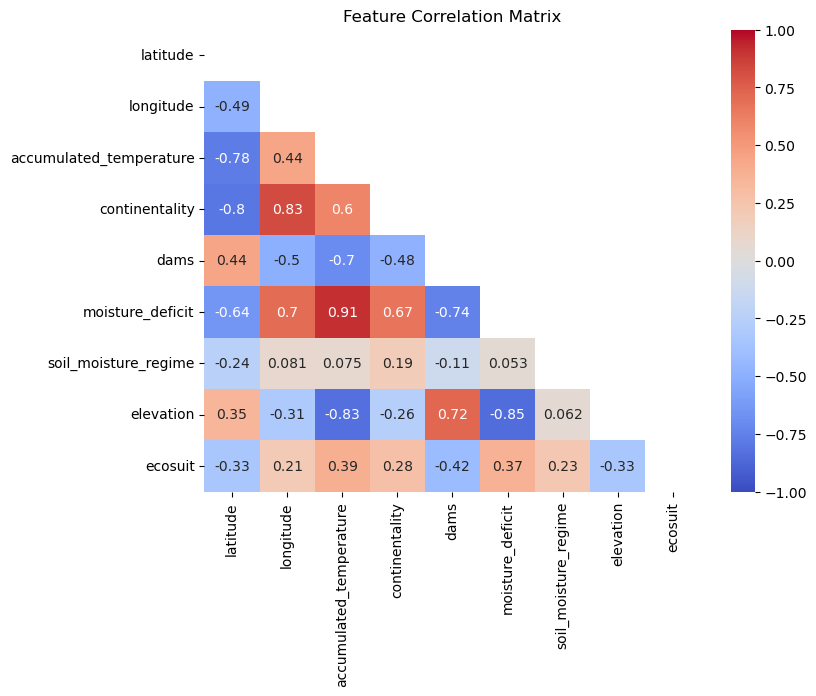

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

#============================
# Remove unwanted cols, encode species col
df_correlation = df_final[['latitude'
                        , 'longitude'
                        , 'accumulated_temperature'
                        , 'continentality'
                        , 'dams'
                        , 'moisture_deficit'
                        , 'soil_moisture_regime'
                        , 'elevation'
                        , 'ecosuit']]

correlation_matrix = df_correlation.corr(method='pearson', numeric_only = False)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask)
plt.title('Feature Correlation Matrix')
plt.show()

In [55]:
import duckdb
duckdb.sql('''select latitude
            , longitude
            , sum(ecosuit) as eco_suitability
        from df_final
        group by latitude, longitude
        --having ecosuit > 0.85
        order by eco_suitability desc;''')

┌──────────────────┬───────────────────────┬────────────────────┐
│     latitude     │       longitude       │  eco_suitability   │
│      double      │        double         │       double       │
├──────────────────┼───────────────────────┼────────────────────┤
│ 50.7694851174243 │     -2.75993440109723 │              14.42 │
│ 50.6730041299607 │     -3.33798459766336 │ 13.950000000000001 │
│ 50.5282335246922 │     -3.62393922719238 │              13.91 │
│   50.29309327014 │     -4.90629080060319 │ 13.640000000000002 │
│ 52.5040778651075 │      -2.3584930407456 │              13.31 │
│ 53.0078991969506 │     -2.32401245816685 │ 13.260000000000002 │
│ 52.7542313424531 │     -2.55948607814224 │              13.24 │
│ 50.6728672095613 │     -4.38459454728205 │              13.21 │
│ 51.5946543050274 │     -3.10048720896228 │              13.21 │
│ 50.2499704684527 │     -3.84628373423485 │              13.21 │
│         ·        │             ·         │                 ·  │
│         

In [100]:
import geopandas as gpd
import matplotlib.pyplot as plt

eng_ag = gpd.read_file('/Users/dougaltoms/Downloads/AgriculturalLandClassificationProvisionalEngland-SHP/data/Agricultural_Land_Classification_Provisional_England.shp')
scot_ag = gpd.read_file('/Users/dougaltoms/Downloads/Hutton_LCA250K_OpenData/LCA_250K.shp')

In [102]:
scot_ag.head()
eng_ag.head()

,geogext,area,alc_grade,perimeter,shape_leng,st_area_sh,st_perimet,geometry
0,TG2,3712.5350,Grade 1,69726.523,69726.522836,3.712535e+07,69726.522836,"MULTIPOLYGON (((600000.000 229930.000, 599950...."
1,TG2,14694.1436,Grade 2,353091.649,353091.648833,1.469414e+08,353091.648833,"MULTIPOLYGON (((604704.819 233398.524, 604735...."
2,TG2,9606.3941,Grade 3,324491.005,324491.004901,9.606394e+07,324491.004901,"MULTIPOLYGON (((617190.000 232200.000, 617470...."
3,TG2,2851.9184,Urban,55930.125,55930.125449,2.851918e+07,55930.125449,"MULTIPOLYGON (((626224.992 232865.008, 626189...."
4,G2K,0.2949,Urban,737.070,737.069549,2.949440e+03,737.069549,"POLYGON ((580180.692 189257.923, 579822.186 18..."


<Axes: >

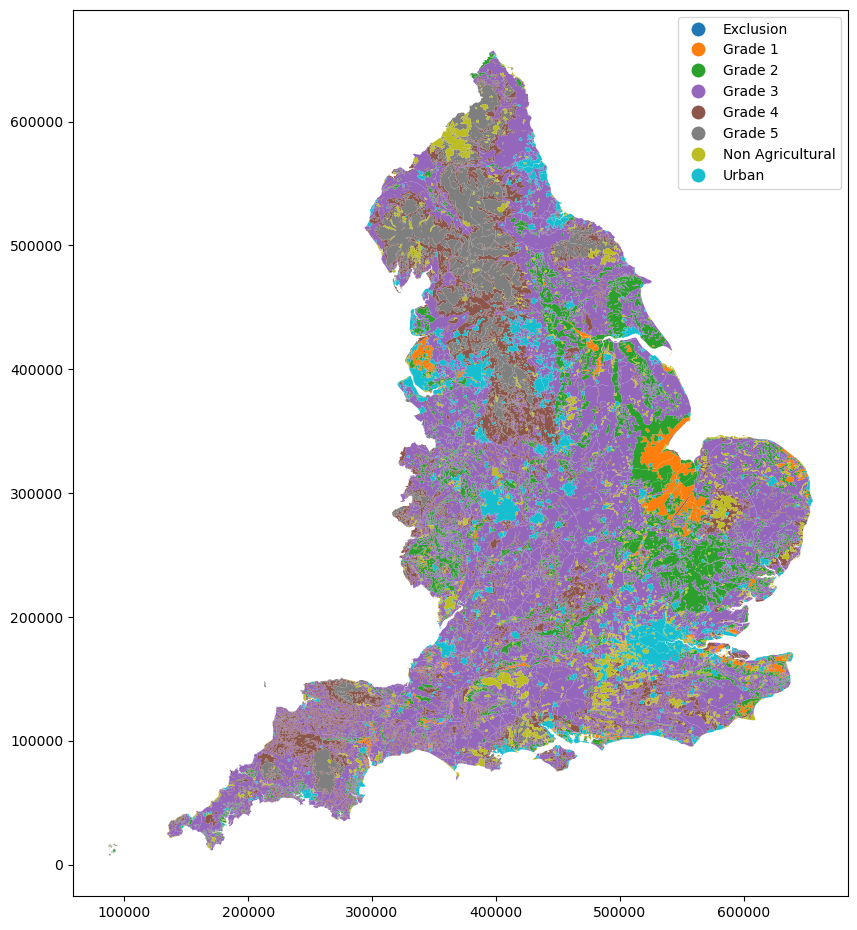

In [104]:
# scot_ag.crs = eng_ag.crs
# gdf = gpd.GeoDataFrame(pd.concat([eng_ag, scot_ag]))
# plt.figure(figsize=(8, 6))
eng_ag.plot(column='alc_grade', figsize=(10, 12), legend=True)
# eng_ag.plot(column='LCCODE', cmap='OrRd')